In [34]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from sklearn.metrics import classification_report, confusion_matrix

from functions.history import load_history

WIDTH = 150
HEIGHT = 150

In [23]:
no_bias_history = load_history('no_bias_history', os.path.join('..', '..'))
biased_history = load_history('biased_history', os.path.join('..', '..'))

In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, label, n):
    plt.semilogy(list(range(len(history['loss']))), history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(list(range(len(history['loss']))), history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


def plot_accuracy(history, label, n):
    plt.plot(history['accuracy'], label=f'Train Accuracy {label}',
             color=colors[n])
    plt.plot(history['val_accuracy'], label=f'Validation Accuracy {label}',
             linestyle='--', color=colors[n])
    plt.title('Metric Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.grid(True)
    plt.legend()

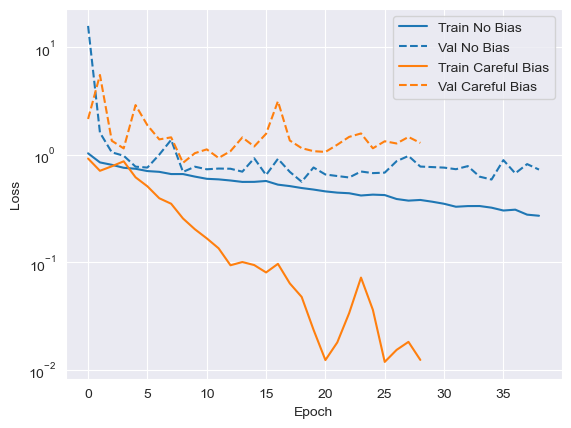

In [25]:
plot_loss(no_bias_history, 'No Bias', 0)
plot_loss(biased_history, 'Careful Bias', 1)

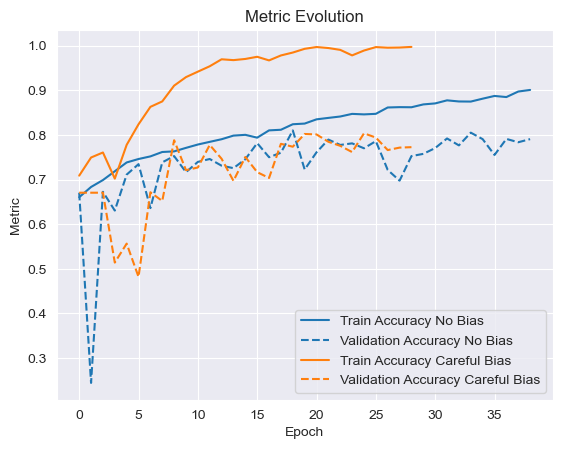

In [26]:
plot_accuracy(no_bias_history, 'No Bias', 0)
plot_accuracy(biased_history, 'Careful Bias', 1)

On average the model with correct initial bias trains shorter and achieves the same accuracy as the one without initial bias, however, the loss is a bit higher and the model overfits. That may be due to the fact that with the correct initial biases low-count classes that were usually wrongly interpreted are now interpreted better. Classification report and a confusion matrix are required to check this.

In [27]:
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))
model_with_biases_name = 'inception_dealing_with_imbalance_3_whole_model_trainable_with_attention_module_on_top_with_initialized_biases_3_9'
model_wo_biases_name = 'inception_dealing_with_imbalance_3_whole_model_trainable_with_attention_module_on_top_no_biases_baseline_2_19'

Found 2000 files belonging to 7 classes.


In [28]:
model_w_biases_path = os.path.join(models_dir, model_with_biases_name)
model_wo_biases_path = os.path.join(models_dir, model_wo_biases_name)
model_w_biases = keras.models.load_model(model_w_biases_path)
model_wo_biases = keras.models.load_model(model_wo_biases_path)

In [29]:
predictions_w_biases = model_w_biases.predict(test_ds)
predictions_wo_biases = model_wo_biases.predict(test_ds)

63/63 [==============================] - 7s 64ms/step


In [33]:
y_pred_labels_w_biases = np.argmax(predictions_w_biases, axis=1)
y_pred_labels_wo_biases = np.argmax(predictions_wo_biases, axis=1)
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)

In [35]:
def show_statistics(y_pred_labels):
    report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
    print(report)

    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.09      0.08      0.08       102
         bkl       0.10      0.11      0.10       219
          df       0.00      0.00      0.00        23
         mel       0.05      0.03      0.04       222
          nv       0.67      0.74      0.71      1341
        vasc       0.04      0.04      0.04        28

    accuracy                           0.52      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.47      0.52      0.49      2000



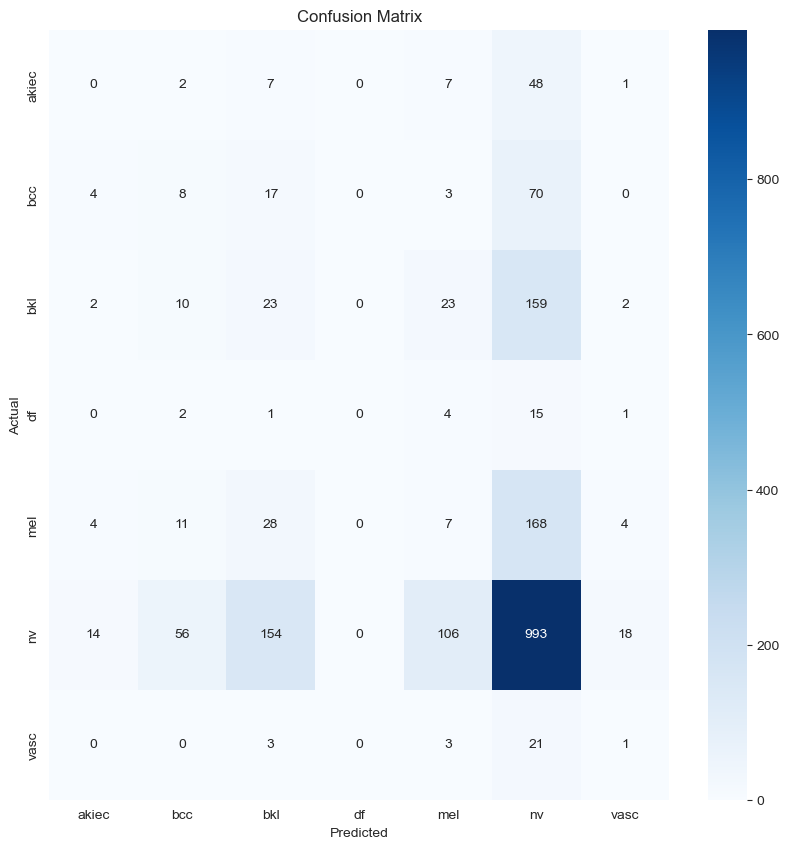

In [36]:
show_statistics(y_pred_labels_w_biases)

              precision    recall  f1-score   support

       akiec       0.06      0.05      0.05        65
         bcc       0.03      0.03      0.03       102
         bkl       0.16      0.16      0.16       219
          df       0.00      0.00      0.00        23
         mel       0.10      0.05      0.07       222
          nv       0.67      0.73      0.70      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.52      2000
   macro avg       0.15      0.15      0.14      2000
weighted avg       0.48      0.52      0.50      2000



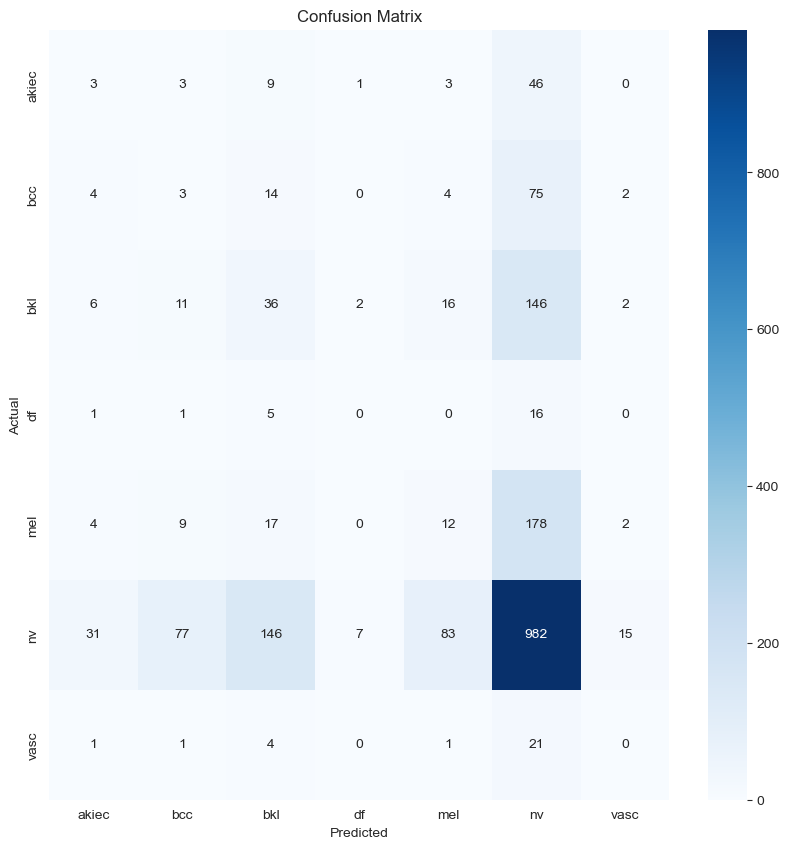

In [37]:
show_statistics(y_pred_labels_wo_biases)

Classification report and confusion matrix show that the model initialized with correct biases performs a bit better in some cases and a bit worse in other ones.